<center style="font-size:25px;padding-bottom:10px;">Final - Procesos Estocásticos</center>
<center style="font-size:20px;padding-bottom:10px;">Máster en Ciencia de Datos -  Universidad Autónoma de Madrid</center>
<center style="font-size:20px;padding-bottom:10px;">José Antonio Álvarez Ocete</center>

In [1]:
from kalman_aux import mk_mat, u_f, B, C, Q, R, sigma_v, sigma_w
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_test_case(i_test_case):
    if i_test_case < 0 or i_test_case > 4:
        exit('i_test_case must be in [1,4]')
    lambdas = [[0.2, 0.1, 0, -0.1], 
              [0.99, 0.1, 0, -0.1],
              [1, 0.1, 0, -0.1],
              [0.2, 0.1, 0, -1]]
    return mk_mat(lambdas[i_test_case-1])

class KalmanFilter():
    def __init__(self, A, B=B, C=C, Q=Q, R=R, sigma_w=sigma_w, sigma_v=sigma_v,
                 u_f=u_f, z_0=0, x_bar_0=0):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.sigma_w = sigma_w
        self.sigma_v = sigma_v
        self.u_f = u_f
        self.z_0 = z_0
        self.x_0 = np.zeros((A.shape[0],))
        self.x_bar_0 = x_bar_0
        
    def get_noisy_vector(self, n, mu=0, sigma=1):
        return np.random.normal(mu, sigma, n)
    
    def simulate_kalman_filter(self, max_time):
        n = self.A.shape[0]
        z_t = self.z_0
        x_t = self.x_0
        x_bar = np.repeat(self.x_bar_0, n)
        P_bar = np.zeros((n,n))
        
        abs_errors = np.array([])
        xs_norms = np.array([])

        for t in range(0, max_time):
            # Compute the next step of the system
            w_t = self.get_noisy_vector(Q.shape[0], self.sigma_w)
            v_t = self.get_noisy_vector(R.shape[0], self.sigma_v)
            x_t = self.A @ x_t + self.B * self.u_f(t) + w_t
            z_t = C @ x_t + v_t

            # Compute the Kalman filter
            K_t = P_bar @ self.C.T @ np.linalg.inv( self.C @ P_bar @ self.C.T + self.R )
            x_hat = x_bar + K_t @ (z_t - self.C @ x_bar)
            P = (np.identity(n) - K_t @ self.C) @ P_bar
            x_bar = self.A @ x_hat + self.B * self.u_f(t)
            P_bar = self.A @ P @ self.A.T + self.Q
            
            # Save the error
            abs_errors = np.append(abs_errors, np.trace(P))
            xs_norms = np.append(xs_norms, np.linalg.norm(x_t))
        
        return abs_errors / xs_norms
    

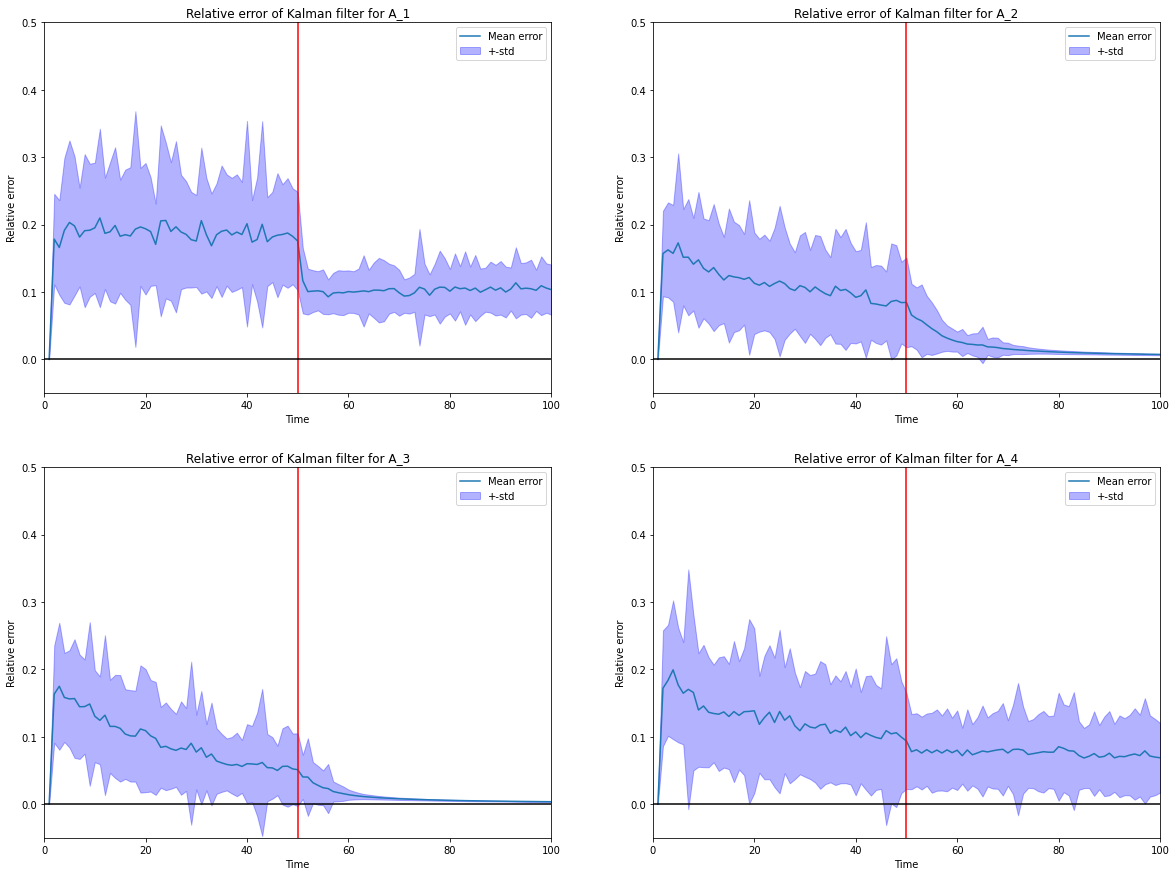

In [17]:
def subplot_errors(axis, x, mean, std, model_name):
    axis.plot(x, mean)
    axis.fill_between(x, mean-std, mean+std, color='b', alpha=.3)
    axis.axvline(x=50, ymin=0, color='r', label='_nolegend_')
    axis.axhline(y=0, xmin=0, color='black', label='_nolegend_')
    axis.set_xlim([0,100])
    axis.set_ylim([-0.05,0.5])
    axis.legend(['Mean error', '+-std'])
    axis.set_xlabel('Time')
    axis.set_ylabel('Relative error')
    axis.set_title('Relative error of Kalman filter for {}'.format(model_name))
    
def plot_errors(models, max_time=100, n_repetitions=100):
    names = [ 'A_{}'.format(i) for i in range(1,5) ]
    x = np.arange(1, 101)
    rel_errors = [
        [ m.simulate_kalman_filter(max_time) for i in range(n_repetitions) ]
        for m in models
    ]
    means = np.mean(rel_errors, axis=1)
    stds = np.std(rel_errors, axis=1)
    
    _, axis = plt.subplots(2, 2, figsize=(20,15))  
    axis = np.array(axis).flatten()
    for i in range(4):
        subplot_errors(axis[i], x, means[i], stds[i], names[i])

np.random.seed(123) 
models = [ KalmanFilter(get_test_case(i)) for i in range(1, 5) ]
plot_errors(models)

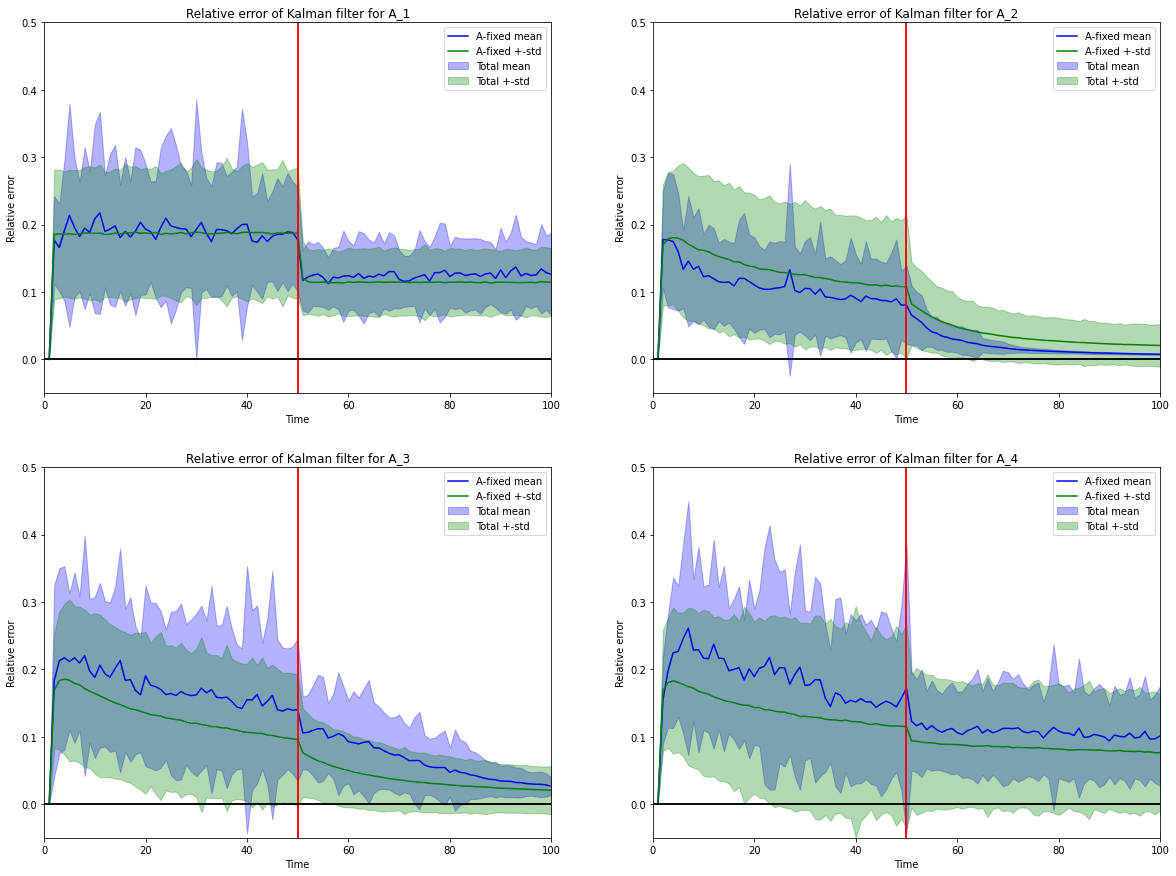

In [20]:
def subplot_errors(axis, x, mean, std, model_name, color):
    axis.plot(x, mean, color=color)
    axis.fill_between(x, mean-std, mean+std, color=color, alpha=.3)
    axis.axvline(x=50, ymin=0, color='r', label='_nolegend_')
    axis.axhline(y=0, xmin=0, color='black', label='_nolegend_')
    axis.set_xlim([0,100])
    axis.set_ylim([-0.05,0.5])
    axis.set_xlabel('Time')
    axis.set_ylabel('Relative error')
    axis.set_title('Relative error of Kalman filter for {}'.format(model_name))
    
def plot_errors_boostrap(max_time=100, n_repetitions=100, n_copies_of_each_model_type=100):
    x = np.arange(1, 101)
    all_models = [
        [ KalmanFilter(get_test_case(i)) for _ in range(n_copies_of_each_model_type) ]
        for i in range(1, 5)
    ]
    rel_errors = [
        [
            [ model.simulate_kalman_filter(max_time) for i in range(n_repetitions) ]
            for model in i_models
        ]
        for i_models in all_models
    ]
    fixed_A_means = [ np.mean(model_A_i_errors[0], axis=0) for model_A_i_errors in rel_errors ]
    fixed_A_stds = [ np.std(model_A_i_errors[0], axis=0) for model_A_i_errors in rel_errors ]
    total_means = np.mean(rel_errors, axis=(1,2))
    total_stds = np.std(rel_errors, axis=(1,2))

    names = [ 'A_{}'.format(i) for i in range(1,5) ]
    _, axis = plt.subplots(2, 2, figsize=(20,15))  
    axis = np.array(axis).flatten()
    for i in range(4):
        subplot_errors(axis[i], x, fixed_A_means[i], fixed_A_stds[i], names[i], color='b')
        subplot_errors(axis[i], x, total_means[i], total_stds[i], names[i], color='green')
        axis[i].legend(['A-fixed mean', 'A-fixed +-std', 'Total mean', 'Total +-std'])

np.random.seed(123)
plot_errors_boostrap()